In [ ]:
!python --version

In [4]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [5]:
# import datasets
credits = pd.read_csv('./FinalProjData/credits.csv')
keywords = pd.read_csv('./FinalProjData/keywords.csv')
movies = pd.read_csv('./FinalProjData/movies_metadata.csv')

# drop columns
movies.drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1, inplace=True)
movies.drop([19730, 29503, 35587], inplace=True) # Incorrect data type, TODO: CHECK

movies['id'] = movies['id'].astype('int64')

# merge datasets to one dataframe
df = movies.merge(keywords, on='id').merge(credits, on='id')

# handle nan
df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')
df.dropna(inplace=True)

In [6]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [7]:
movies.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0


In [8]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [9]:
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [10]:
print(df['genres'][0])
print(df['production_companies'][0])
print(df['production_countries'][0])

[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
[{'name': 'Pixar Animation Studios', 'id': 3}]
[{'iso_3166_1': 'US', 'name': 'United States of America'}]


In [11]:
# extract strings from object columns
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)
    
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [12]:
print(df['genres'][0])
print(df['production_companies'][0])
print(df['production_countries'][0])

Animation, Comedy, Family
Pixar Animation Studios
United States of America


In [13]:
# Cleaned dataset
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42373 non-null  object 
 1   budget                42373 non-null  object 
 2   genres                42373 non-null  object 
 3   id                    42373 non-null  int64  
 4   original_language     42373 non-null  object 
 5   original_title        42373 non-null  object 
 6   overview              42373 non-null  object 
 7   popularity            42373 non-null  object 
 8   production_companies  42373 non-null  object 
 9   production_countries  42373 non-null  object 
 10  release_date          42373 non-null  object 
 11  revenue               42373 non-null  float64
 12  runtime               42373 non-null  float64
 13  spoken_languages      42373 non-null  object 
 14  tagline               42373 non-null  object 
 15  vote_average       

In [15]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

<b>Adult</b>: A boolean column indicating whether the movie is for adults.
<br /><b>Budget</b>: The budget of the movie, likely in dollars.
<br /><b>Genres</b>: A string of movie genres, separated by commas.
<br /><b>Id</b>: A unique identifier for each movie.
<br /><b>Original Language</b>: The language in which the movie was originally made.
<br /><b>Original Title</b>: The original title of the movie.
<br /><b>Overview</b>: A brief description or synopsis of the movie.
<br /><b>Popularity</b>: A metric indicating the movie's popularity.
<br /><b>Production Companies</b>: The companies involved in producing the movie, separated by commas.
<br /><b>Production Countries</b>: The countries where the movie was produced, separated by commas.
<br /><b>Release Date</b>: The date on which the movie was released.
<br /><b>Revenue</b>: The total revenue generated by the movie, likely in dollars.
<br /><b>Runtime</b>: The runtime of the movie in minutes.
<br /><b>Spoken Languages</b>: The languages spoken in the movie, separated by commas.
<br /><b>Tagline</b>: A tagline associated with the movie.
<br /><b>Vote Average</b>: The average rating given to the movie by viewers.
<br /><b>Vote Count</b>: The number of votes or ratings received by the movie.
<br /><b>Keywords</b>: Keywords or phrases associated with the movie, separated by commas.
<br /><b>Crew</b>: The main crew members involved in the production of the movie, likely in a string format.
<br /><b>Characters</b>: The main characters in the movie, likely in a string format.
<br /><b>Actors</b>: The actors who appear in the movie, separated by commas.
<br /><b>Release Year</b>: The year in which the movie was released.

<b>Visualization</b>

(0.0, 2.0, 0.9, 1.2)

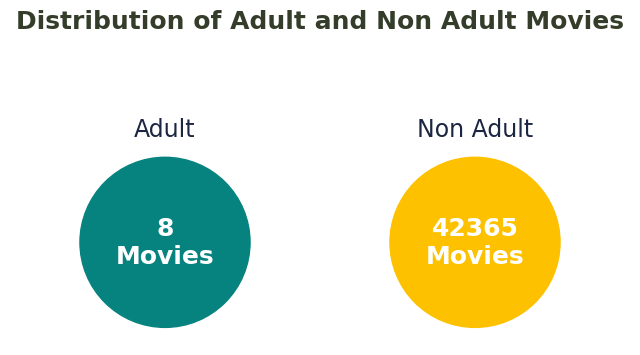

In [16]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

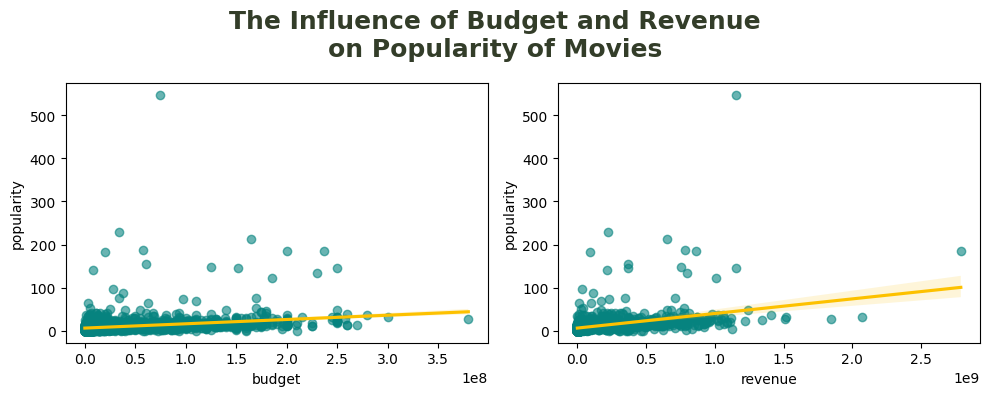

In [17]:
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

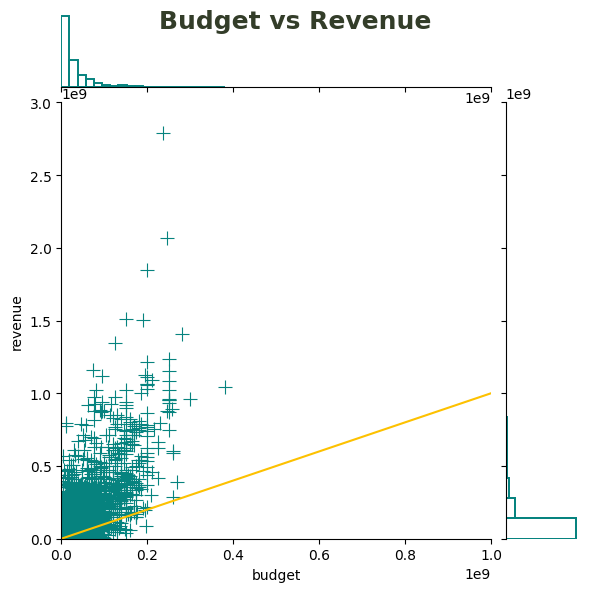

In [18]:
ax = sns.jointplot(data=df[(df['budget'] != 0) & (df['revenue'] != 0)], x='budget', y='revenue',
                   marker="+", s=100, marginal_kws=dict(bins=20, fill=False), color='#06837f')
ax.fig.suptitle('Budget vs Revenue', fontsize=18, weight=600, color='#333d29')
ax.ax_joint.set_xlim(0, 1e9)
ax.ax_joint.set_ylim(0, 3e9)
ax.ax_joint.axline((1,1), slope=1, color='#fdc100')

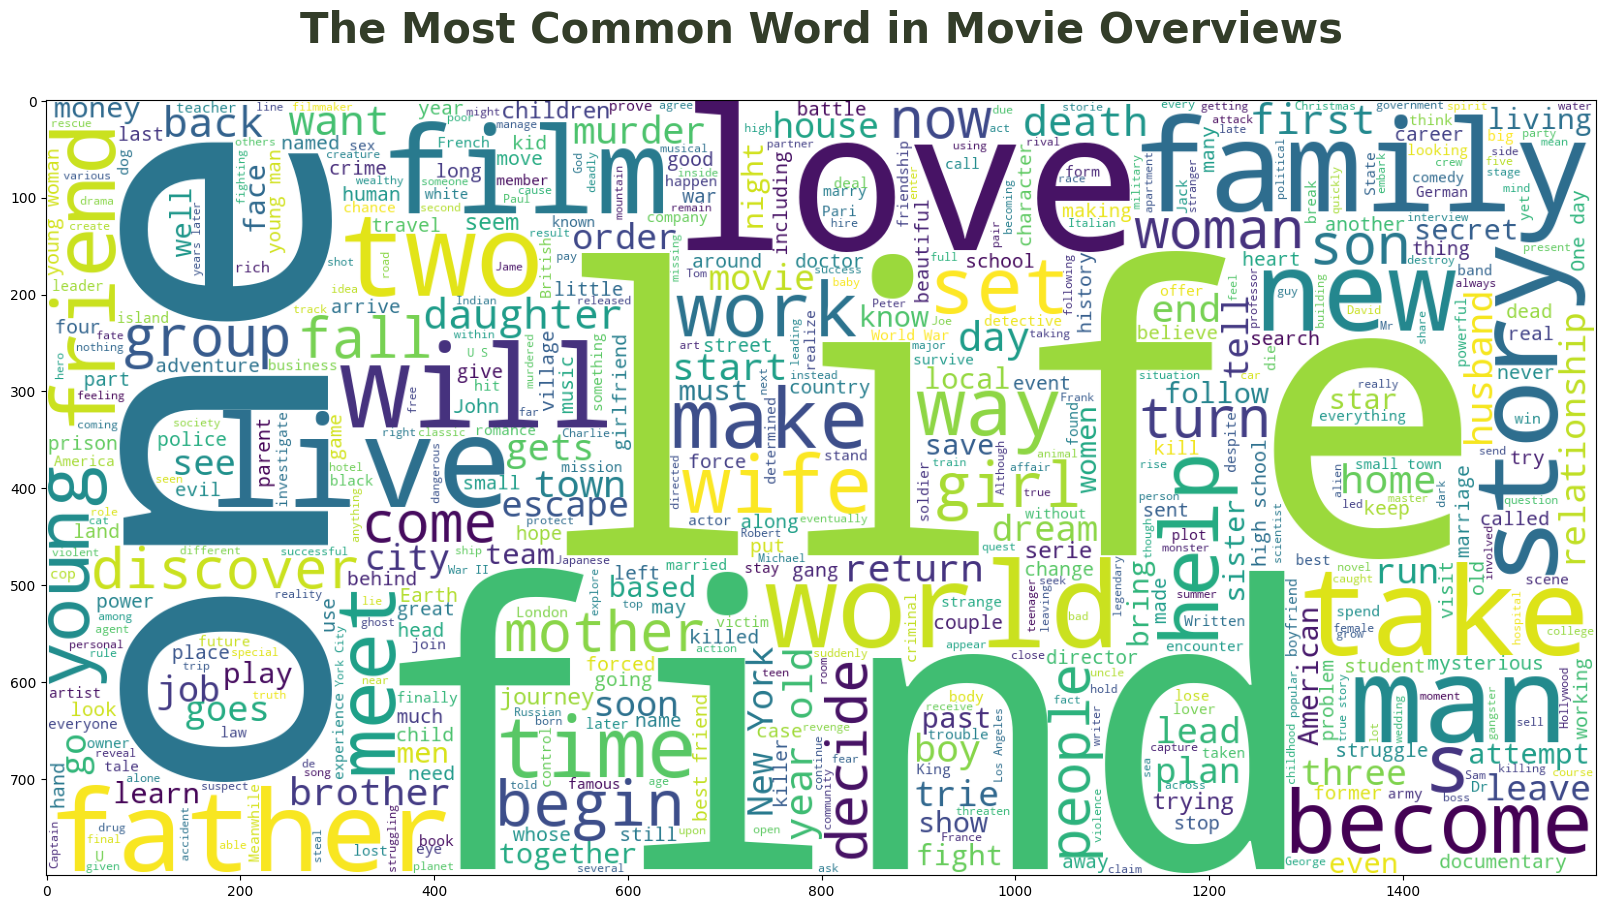

In [19]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(df['overview']))

plt.imshow(wc)

(-1.25, 1.25, -1.25, 1.25)

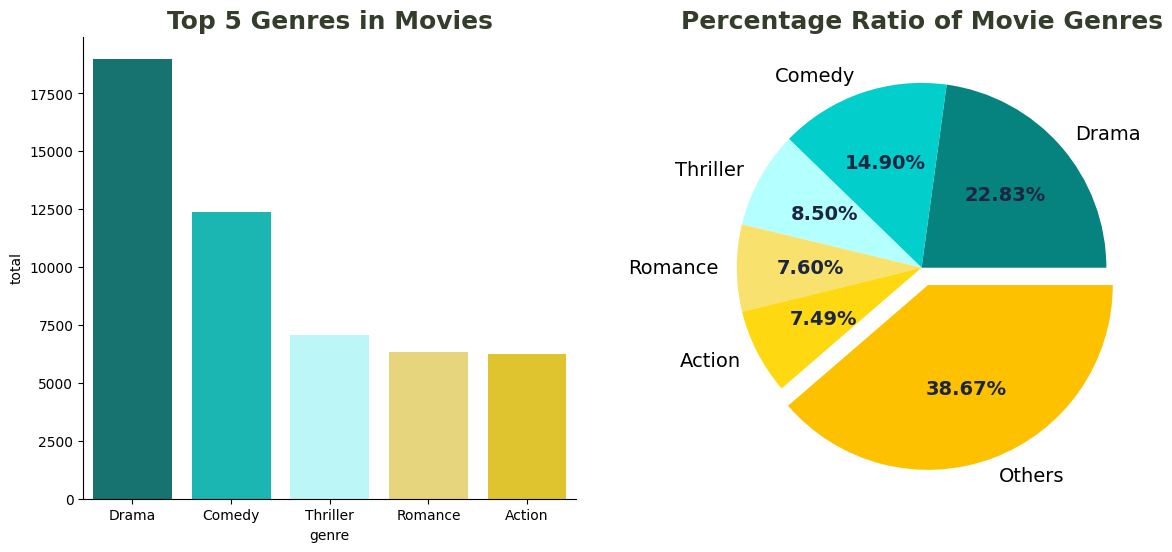

In [20]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

In [21]:
df.to_csv("all")

In [22]:
# TODO: Calculate uniqe values each categorial columns
len(set(genres_list))

# TODO: remove non insteresting visualization and leave just the most important

21

Text(0.5, 1.0, 'Total Released Movie by Date')

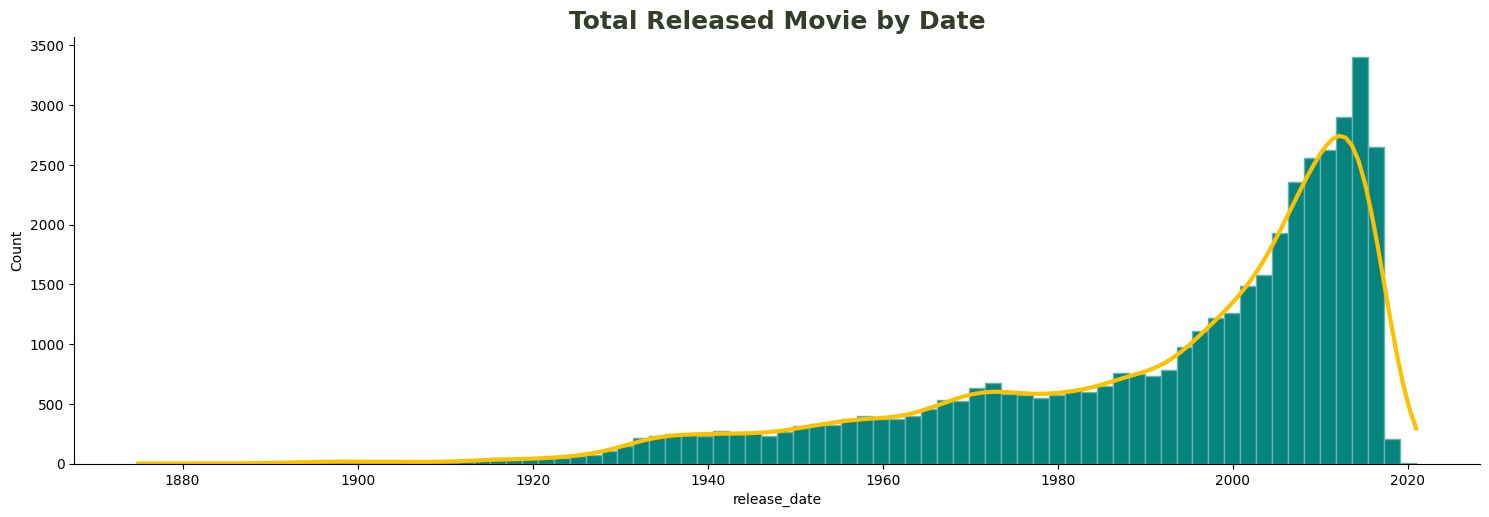

In [23]:
sns.displot(data=df, x='release_date', kind='hist', kde=True,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29')

In [24]:
original_language_list = []
for i in df['original_language']:
    original_language_list.extend(i.split(', '))
    
spoken_languages_list = []
for i in df['spoken_languages']:
    if i != '':
        spoken_languages_list.extend(i.split(', '))

actors_list = []
for i in df['actors']:
    if i != '':
        actors_list.extend(i.split(', '))
        
crew_list = []
for i in df['crew']:
    if i != '':
        crew_list.extend(i.split(', '))

company_list = []
for i in df['production_companies']:
    if i != '':
        company_list.extend(i.split(', '))
    
country_list = []
for i in df['production_countries']:
    if i != '':
        country_list.extend(i.split(', '))

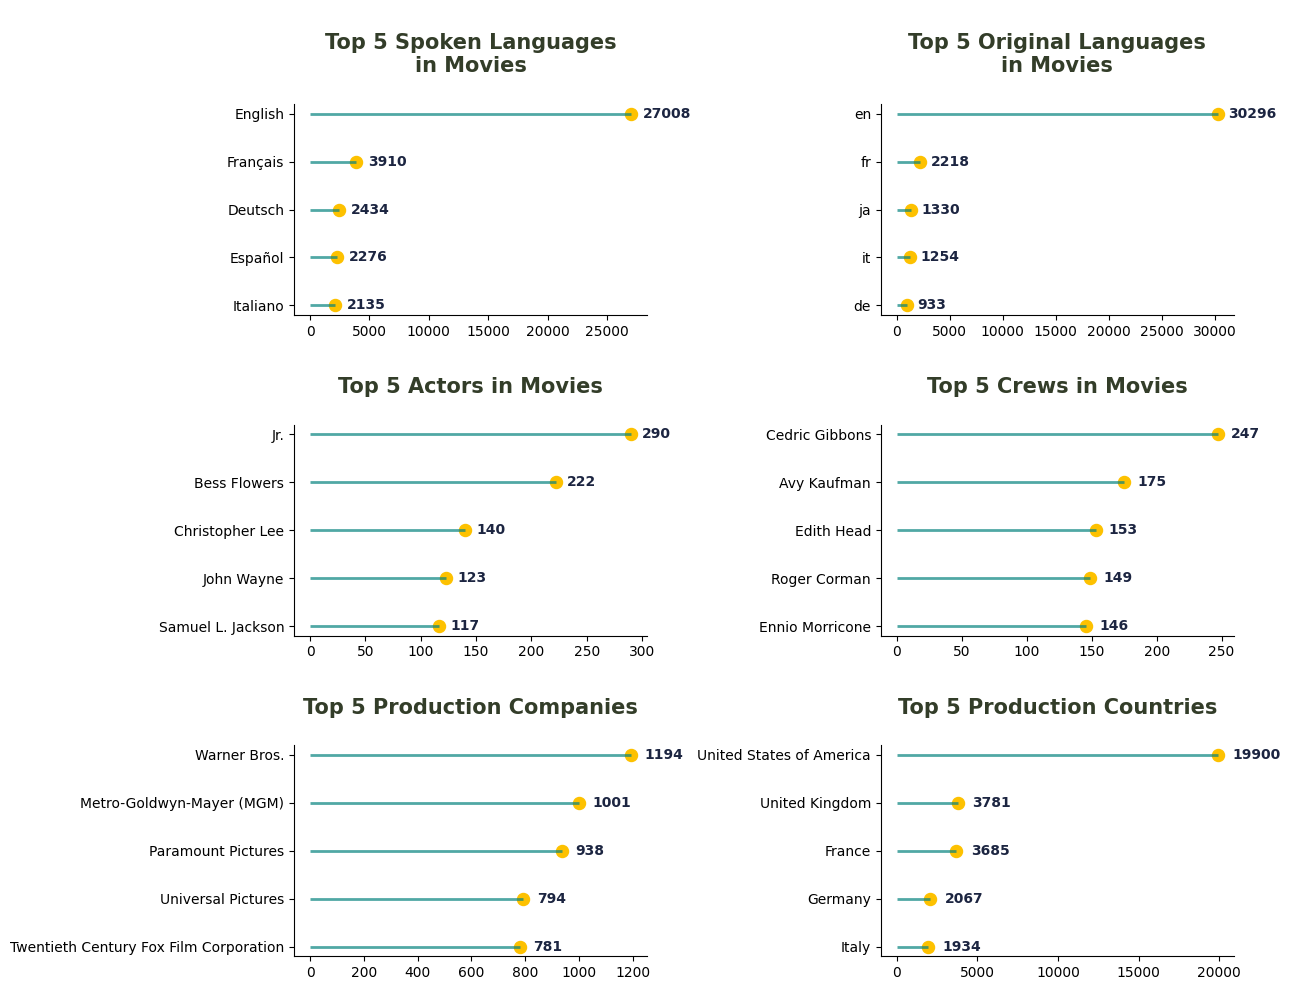

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 10))

# Spoken language plot
df_plot1 = pd.DataFrame(Counter(spoken_languages_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,0].hlines(y=df_plot1['language'], xmin=0, xmax=df_plot1['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,0].scatter(x=df_plot1['total'], y=df_plot1['language'], s = 75, color='#fdc100')
axes[0,0].set_title('\nTop 5 Spoken Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot1['total']):
    axes[0,0].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Original Language plot
df_plot2 = pd.DataFrame(Counter(original_language_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,1].hlines(y=df_plot2['language'], xmin=0, xmax=df_plot2['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,1].scatter(x=df_plot2['total'], y=df_plot2['language'], s = 75, color='#fdc100')
axes[0,1].set_title('\nTop 5 Original Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot2['total']):
    axes[0,1].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Actor plot
df_plot3 = pd.DataFrame(Counter(actors_list).most_common(5), columns=['actor', 'total']).sort_values(by='total', ascending=True)
axes[1,0].hlines(y=df_plot3['actor'], xmin=0, xmax=df_plot3['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,0].scatter(x=df_plot3['total'], y=df_plot3['actor'], s = 75, color='#fdc100')
axes[1,0].set_title('\nTop 5 Actors in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot3['total']):
    axes[1,0].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Crew plot
df_plot4 = pd.DataFrame(Counter(crew_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[1,1].hlines(y=df_plot4['name'], xmin=0, xmax=df_plot4['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,1].scatter(x=df_plot4['total'], y=df_plot4['name'], s = 75, color='#fdc100')
axes[1,1].set_title('\nTop 5 Crews in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot4['total']):
    axes[1,1].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Company plot
df_plot5 = pd.DataFrame(Counter(company_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,0].hlines(y=df_plot5['name'], xmin=0, xmax=df_plot5['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,0].scatter(x=df_plot5['total'], y=df_plot5['name'], s = 75, color='#fdc100')
axes[2,0].set_title('\nTop 5 Production Companies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot5['total']):
    axes[2,0].text(value+50, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Country plot
df_plot6 = pd.DataFrame(Counter(country_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,1].hlines(y=df_plot6['name'], xmin=0, xmax=df_plot6['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,1].scatter(x=df_plot6['total'], y=df_plot6['name'], s = 75, color='#fdc100')
axes[2,1].set_title('\nTop 5 Production Countries\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot6['total']):
    axes[2,1].text(value+900, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
sns.despine()
plt.tight_layout()

Text(0.5, 1.0, 'The Relationship Between Rating and Popularity')

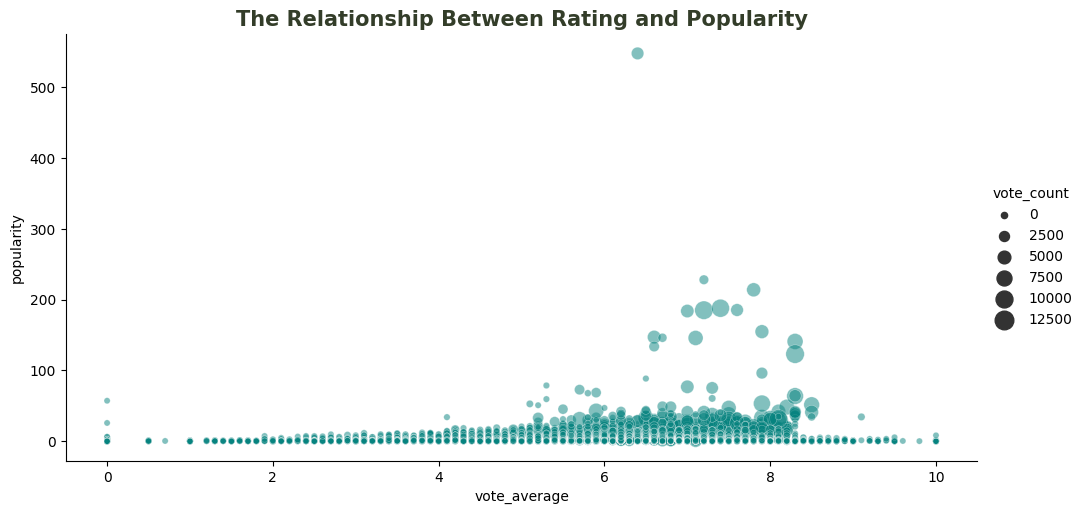

In [26]:
# TODO: ?
sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#06837f')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')

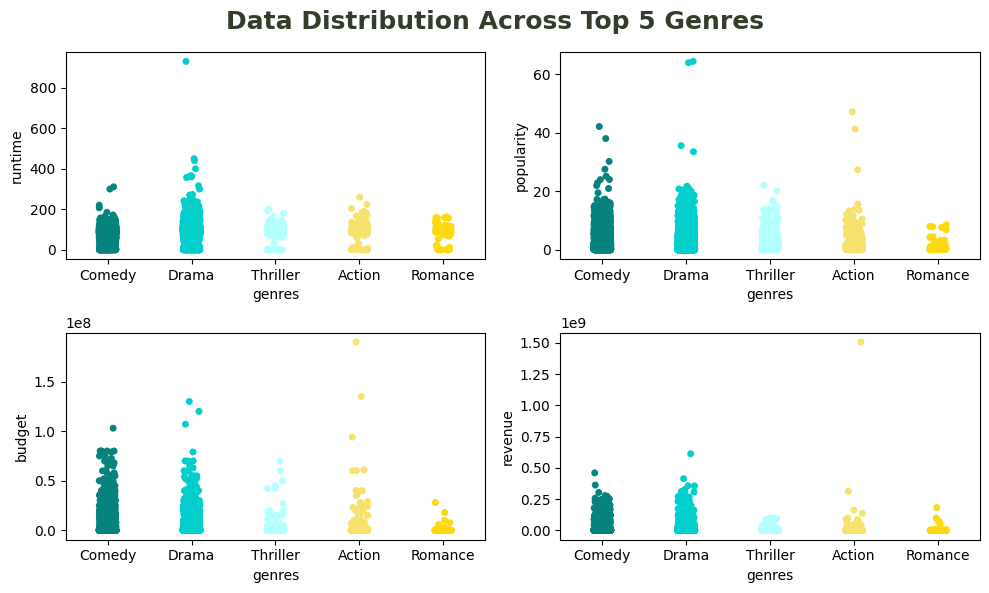

In [27]:
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
df_plot = df[df['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600, color='#333d29')
for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

plt.tight_layout()

<b>Insights:</b><br />
The movie genre that has the longest runtime is drama<br />
The least popular genre in the top 5 is romance<br />
Action movies spent more money than the rest of the movies<br />
One of the action movies got a vast profit compared to the others

<Axes: title={'center': 'Correlation of Movie Features\n'}>

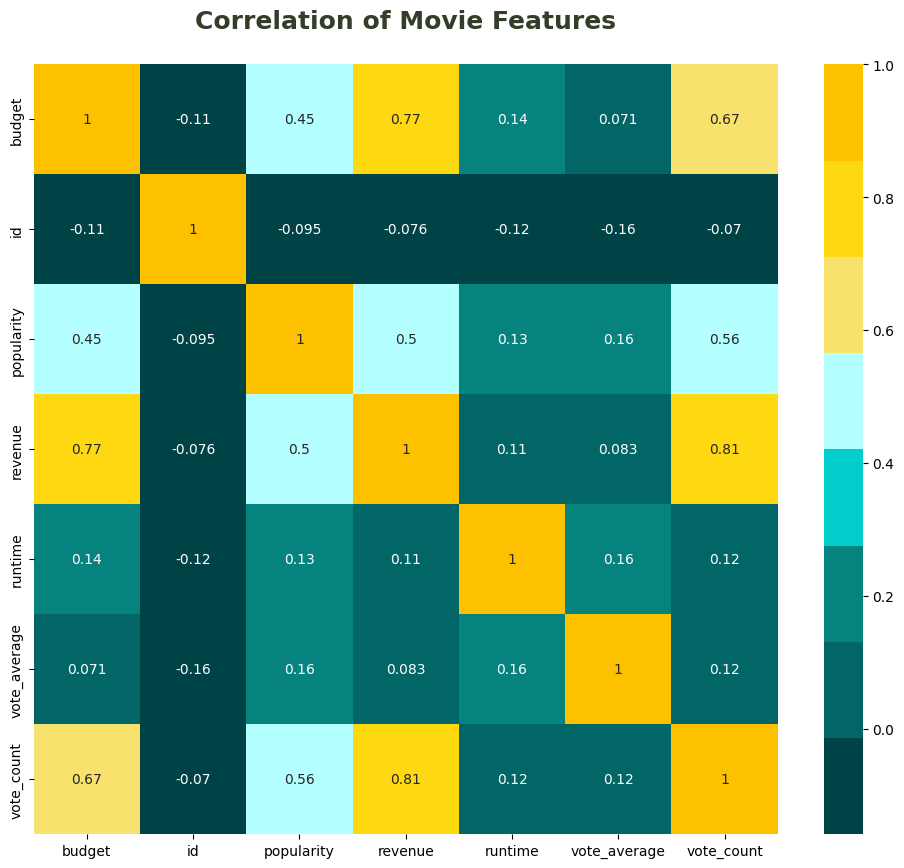

In [30]:
plt.figure(figsize=(12,10))
plt.title('Correlation of Movie Features\n', fontsize=18, weight=600, color='#333d29')
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap=['#004346', '#036666', '#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

<b>Insights:</b><br />
Vote count, budget, and popularity are 3 dominant features that will determined the revenue of the movies

<b><h2>recommendation System</h2></b>

<b>Content-Based recommendation System</b>

There are tons of valuable information such as genre, overview, etc. Later, we are going to use this information to make our recommender system more robust. we extract those information inside bag of words then combined it with weighted average to get the final similarity for the movies

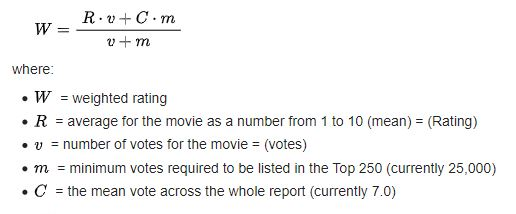

In [31]:
df['vote_average']

0        7.7
1        6.9
2        6.5
3        6.1
4        5.7
        ... 
42368    7.0
42369    3.5
42370    9.0
42371    0.0
42372    0.0
Name: vote_average, Length: 42373, dtype: float64

In [32]:
R = df['vote_average']
v = df['vote_count']
# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = df['vote_count'].quantile(0.8)
C = df['vote_average'].mean()

df['weighted_average'] = (R*v + C*m)/(v+m)

In [33]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

Let's take 40% weight for weigthed average and 60% weight for popularity considering people don't want to miss a hype movie even the reviews and ratings are poor. 
Next up, we create a new column called score which stores the result

In [34]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6

In [35]:
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.603532,0.841413
Big Hero 6,0.390602,0.827561,0.565386
Baby Driver,0.416507,0.727736,0.540998
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054
Pulp Fiction,0.257449,0.908395,0.517827
Deadpool,0.343132,0.764657,0.511742
Gone Girl,0.282748,0.843413,0.507014
The Dark Knight,0.224968,0.909123,0.498630
Avatar,0.338036,0.732643,0.495879


In [36]:
# we will combine those score with the similarity score

content_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew', 'characters', 'actors']]
content_df

,original_title,adult,genres,overview,production_companies,tagline,keywords,crew,characters,actors
0,Toy Story,False,"Animation, Comedy, Family","Led by Woody, Andy's toys live happily in his ...",Pixar Animation Studios,,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,Jumanji,False,"Adventure, Fantasy, Family",When siblings Judy and Peter discover an encha...,"TriStar Pictures, Teitler Film, Interscope Com...",Roll the dice and unleash the excitement!,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,Grumpier Old Men,False,"Romance, Comedy",A family wedding reignites the ancient feud be...,"Warner Bros., Lancaster Gate",Still Yelling. Still Fighting. Still Ready for...,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,Waiting to Exhale,False,"Comedy, Drama, Romance","Cheated on, mistreated and stepped on, the wom...",Twentieth Century Fox Film Corporation,Friends are the people who let you be yourself...,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,Father of the Bride Part II,False,Comedy,Just when George Banks has recovered from his ...,"Sandollar Productions, Touchstone Pictures",Just When His World Is Back To Normal... He's ...,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."
...,...,...,...,...,...,...,...,...,...,...
42368,The Burkittsville 7,False,Horror,A film archivist revisits the story of Rustin ...,"Neptune Salad Entertainment, Pirie Productions","Do you know what happened 50 years before ""The...","witch, mythology, legend, serial killer, mocku...","Ben Rock, Ben Rock","Branwall, Sarah Didonna, Kyle Brody, Bill Barn...","Monty Bane, Lucy Butler, David Grammer, Bill D..."
42369,Caged Heat 3000,False,Science Fiction,It's the year 3000 AD. The world's most danger...,Concorde-New Horizons,,,"Roger Corman, Mike Elliott, Aaron Osborne, Mik...","Kira (as Cassandra Leigh), Daly, Ruggs, Lewis,...","Lisa Boyle, Kena Land, Zaneta Polard, Don Yana..."
42370,Siglo ng Pagluluwal,False,Drama,An artist struggles to finish his work while a...,Sine Olivia,,"artist, play, pinoy","Lav Diaz, Lav Diaz, Dante Perez, Lav Diaz, Lav...","Sister Angela, Homer, Crazy Woman/Virgin, Aman...","Angel Aquino, Perry Dizon, Hazel Orencio, Joel..."
42371,Satana likuyushchiy,False,,"In a small town live two brothers, one a minis...",Yermoliev,,,"Yakov Protazanov, Joseph N. Ermolieff",", , , ,","Iwan Mosschuchin, Nathalie Lissenko, Pavel Pav..."


In [37]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [38]:
content_df['adult'] = content_df['adult'].apply(remove_punc)
content_df['genres'] = content_df['genres'].apply(remove_punc)
content_df['overview'] = content_df['overview'].apply(remove_punc)
content_df['production_companies'] = content_df['production_companies'].apply(separate)
content_df['tagline'] = content_df['tagline'].apply(remove_punc)
content_df['keywords'] = content_df['keywords'].apply(separate)
content_df['crew'] = content_df['crew'].apply(separate)
content_df['characters'] = content_df['characters'].apply(separate)
content_df['actors'] = content_df['actors'].apply(separate)

content_df['bag_of_words'] = ''
content_df['bag_of_words'] = content_df[content_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
content_df.set_index('original_title', inplace=True)

content_df = content_df[['bag_of_words']]
content_df.head()

,bag_of_words
original_title,
Toy Story,false animation comedy family led by woody and...
Jumanji,false adventure fantasy family when siblings j...
Grumpier Old Men,false romance comedy a family wedding reignite...
Waiting to Exhale,false comedy drama romance cheated on mistreat...
Father of the Bride Part II,false comedy just when george banks has recove...


A common method to find similarity between 2 movies is a method called cosine similarity. There are of course a bunch of methods that you can try such as euclidean and sigmoidto know which one performs best

However, calculate similarity for all the movies require an expensive resources. So, because we have limited memory, we only take the first 10000 movies from weighted_df_sorted

In [39]:
content_df = weighted_df_sorted[:20000].merge(content_df, left_index=True, right_index=True, how='left')
#content_df = weighted_df_sorted.merge(content_df, left_index=True, right_index=True, how='left')
tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(content_df['bag_of_words'])
tfidf_matrix.shape

(20000, 45128)

In [40]:
import pickle
# export pickle
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf,file)
    
# import pickle
# pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))

In [41]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(20000, 20000)

In [42]:
content_df.head()

,popularity,weighted_average,score,bag_of_words
original_title,,,,
Minions,1.000000,0.603532,0.841413,false family animation adventure comedy minion...
Big Hero 6,0.390602,0.827561,0.565386,false adventure family animation action comedy...
Baby Driver,0.416507,0.727736,0.540998,false action crime after being coerced into wo...
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054,false action adventure comedy science fiction ...
Pulp Fiction,0.257449,0.908395,0.517827,false thriller crime a burgerloving hit man hi...


In [43]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = content_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T
    
    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    # TODO play around with the number
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight
    
    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [44]:
predict('Toy Story', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
original_title,,,
Toy Story,0.348515,1.000000,0.804555
Toy Story 2,0.317785,0.554098,0.483204
Toy Story 3,0.336500,0.272078,0.291405
Toy Story of Terror!,0.282269,0.278598,0.279699
Minions,0.841413,0.004781,0.255771
Small Fry,0.256223,0.248446,0.250779
Hawaiian Vacation,0.266277,0.243513,0.250342
WALL·E,0.348682,0.193893,0.240330
Finding Nemo,0.346185,0.190416,0.237147


<h3><b>Deep Learning</b></h3>

<b>Medium Article</b>

In [45]:
from __future__ import annotations

import os
import sys
from datetime import datetime
from typing import Any, Dict, Generator, List, Tuple, Union

#sys.path.append('../../two-tower-ml')

import warnings

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

#from utils.logger import get_logger

#logger = get_logger()

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print(tf.__version__, keras.__version__)

# Set the maximum number of columns to display
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
tf.random.set_seed(42)

#logger.info('Getting libraries and packages')

path_folder = '.\FinalProjData\ml-100k'


2.15.0 2.15.0


In [46]:
#Data Loading
items = 'u.item'
ratings = 'ua.base'

movies_path = os.path.join(path_folder, items)
ratings_path = os.path.join(path_folder, ratings)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies_df = pd.read_csv(movies_path, sep='|', encoding='latin-1', names=i_cols)
ratings_df = pd.read_csv(ratings_path,  sep='\t', encoding='latin-1', names=r_cols).dropna()

In [47]:
# replacing blank space for underlines in the column names
cols = [col.lower().replace(' ', '_').replace('[', '').replace(']', '') for col in movies_df.columns]
movies_df.columns = cols
movies_df.head(2)

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children's,comedy,crime,documentary,drama,fantasy,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [48]:
# forcing ids to become string instead of integers
ratings_df['user_id'] = 'id_' + ratings_df['user_id'].astype(str)
ratings_df['movie_id'] = 'id_' + ratings_df['movie_id'].astype(str)
movies_df['movie_id'] = 'id_' + movies_df['movie_id'].astype(str)

<b>Preprocessing</b>

In [49]:
def hour_to_shift(timestamps):

    shift = 0

    # Determine the shift based on the hour
    if 6 <= timestamps < 10:
        shift = "Breakfast"
    elif 10 <= timestamps < 14:
        shift="Lunch"
    elif 14 <= timestamps < 18:
        shift="Afternoon"
    elif 18 <= timestamps < 22:
        shift="Dinner"
    else:
        shift="Noon"

    return shift

In [50]:
# Let's divide the users by segments. Heavy and light users. 
# The aim is to predict a batch of candidates for the light users using the heavy user's past interactions.
# light_user_ratings_df will be used as the test dataset for serving

heavy_user_df = ratings_df['user_id'].value_counts()[:600].index
light_user_df = ratings_df['user_id'].value_counts()[600:].index
heavy_user_ratings_df = ratings_df.query('user_id in @heavy_user_df')
light_user_ratings_df = ratings_df.query('user_id in @light_user_df')

In [51]:
# let's preprocess some temporal features
heavy_user_ratings_df['ordered_unix_timestamp'] = pd.to_datetime(heavy_user_ratings_df['unix_timestamp'], unit='s')
heavy_user_ratings_df['shift']=heavy_user_ratings_df['ordered_unix_timestamp'].dt.hour.apply(lambda x: hour_to_shift(x))
heavy_user_ratings_df['day_of_week']=heavy_user_ratings_df['ordered_unix_timestamp'].dt.day_name()

light_user_ratings_df['ordered_unix_timestamp'] = pd.to_datetime(light_user_ratings_df['unix_timestamp'], unit='s')
light_user_ratings_df['shift']=light_user_ratings_df['ordered_unix_timestamp'].dt.hour.apply(lambda x: hour_to_shift(x))
light_user_ratings_df['day_of_week']=light_user_ratings_df['ordered_unix_timestamp'].dt.day_name()

In [52]:
# let's split the dataset between, train/val/test

# Sort the DataFrame by user_id and unix_timestamp
heavy_user_ratings_df = heavy_user_ratings_df.sort_values(['user_id', 'ordered_unix_timestamp'])

train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

# Group the DataFrame by user_id
grouped = heavy_user_ratings_df.groupby('user_id')

# Iterate over each user group and split the data into train, validation, and test sets
for _, group in grouped:
    # Get the unique timestamps for the user
    unique_timestamps = group['ordered_unix_timestamp'].unique()
    
    # Determine the split points for train, validation, and test sets
    train_split = int(0.8 * len(unique_timestamps))
    val_split = int(0.9 * len(unique_timestamps))
    
    # Split the unique timestamps
    train_timestamps = unique_timestamps[:train_split]
    val_timestamps = unique_timestamps[train_split:val_split]
    test_timestamps = unique_timestamps[val_split:]

    # Split the data based on the timestamps
    train = group[group['ordered_unix_timestamp'].isin(train_timestamps)]
    val = group[group['ordered_unix_timestamp'].isin(val_timestamps)]
    test = group[group['ordered_unix_timestamp'].isin(test_timestamps)]
    
    # Append the split data to the respective datasets
    train_df = pd.concat([train_df, train], axis = 0)
    val_df = pd.concat([val_df,val], axis = 0)
    test_df = pd.concat([test_df, test], axis = 0)

# Print the resulting datasets
print("Train dataset:")
print(train_df.shape)
print("\nValidation dataset:")
print(val_df.shape)
print("\nTest dataset:")
print(test_df.shape)

Train dataset:
(68050, 7)

Validation dataset:
(7724, 7)

Test dataset:
(8210, 7)


In [53]:
# Now, preprocessing some features regarding the genre of the movie. 
# In this case, let's grab the first genre presented. 

genre_columns = ['unknown', 'action', 'adventure', 'animation', "children's",
       'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film-noir',
       'horror', 'musical', 'mystery', 'romance', 'sci-fi', 'thriller', 'war',
       'western']

# Create the 'movie_genre' column by joining the genre names
movies_df['movie_genre'] = movies_df[genre_columns].apply(
    lambda x: ', '.join([col for col, val in zip(genre_columns, x) if val == 1]),
    axis=1
)

movies_df = pd.concat([
    movies_df,
    movies_df['movie_genre'].str.split(', ', expand=True).rename(columns={0:'genre1', 1:'genre2',2:'genre3',3:'genre4', 4:'genre5', 5:'genre5'})
],axis=1)

movies_df.head(2)

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children's,comedy,crime,documentary,drama,fantasy,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western,movie_genre,genre1,genre2,genre3,genre4,genre5,genre5
0,id_1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"animation, children's, comedy",animation,children's,comedy,None,None,None
1,id_2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"action, adventure, thriller",action,adventure,thriller,None,None,None


In [54]:
# preprocessing some features regarding the past consumer behavior of the movies. 
# In this case, total number of views and rating's average score

additional_features = train_df.groupby('movie_id').aggregate({'user_id':'count','rating':'mean'}).rename(columns={'user_id':'total_views', 'rating':'avg_score'}).reset_index()
additional_features['avg_score'] = additional_features['avg_score'].round(2)
additional_features

,movie_id,total_views,avg_score
0,id_1,309,3.87
1,id_10,65,3.75
2,id_100,352,4.16
3,id_1000,8,3.00
4,id_1001,14,2.00
...,...,...,...
1598,id_995,18,3.22
1599,id_996,8,2.25
1600,id_997,7,2.43
1601,id_998,6,2.33


In [55]:
# adding those additional features to the train/val/test/movie dataframes 
# There are several other features to be created (freshness, indie/popular...). 
# For the purpose of this notebook, i wanted to create variables enough for the model but not that much now

columns = [
    'movie_id',
    'movie_title',
    'movie_genre',
    'total_views',
    'avg_score', 
    'genre1',
]

movies_df = (movies_df
             .merge(additional_features,left_on='movie_id', right_on='movie_id',how = 'left')
)

train_df = (train_df
            .merge(movies_df[columns],left_on='movie_id', right_on='movie_id',how = 'left')
            )

val_df = (
    val_df
    .merge(movies_df[columns],left_on='movie_id', right_on='movie_id',how = 'left')
)

test_df = (test_df
           .merge(movies_df[columns],left_on='movie_id', right_on='movie_id',how = 'left')
)

light_user_ratings_df = (light_user_ratings_df
           .merge(movies_df[columns],left_on='movie_id', right_on='movie_id',how = 'left')
)

In [56]:
# droping no need variables

train_df = train_df.drop(['rating','ordered_unix_timestamp'],axis=1)
val_df = val_df.drop(['rating','ordered_unix_timestamp'],axis=1)
test_df = test_df.drop(['rating','ordered_unix_timestamp'],axis=1)

light_user_ratings_df = light_user_ratings_df.drop(['rating','ordered_unix_timestamp'],axis=1)

In [57]:
# convert pandas dataframe to tf dataframe

train_tf = tf.data.Dataset.from_tensor_slices(train_df.to_dict('list'))#.prefetch(2)
val_tf = tf.data.Dataset.from_tensor_slices(val_df.to_dict('list'))#.prefetch(2)
test_tf = tf.data.Dataset.from_tensor_slices(test_df.to_dict('list'))#.prefetch(2)

movies_tf = tf.data.Dataset.from_tensor_slices(dict(movies_df[columns].to_dict('list')))#.prefetch(2)

In [58]:
# convert tf dataframe to this json formated tf dataframe. 
# Format required for training the model

train = train_tf.map(lambda x: {
    "user_id": x["user_id"],
    "movie_id": x["movie_id"],
    "movie_title": x["movie_title"],
    # "unix_timestamp": x["unix_timestamp"],
    "shift": x["shift"],
    "day_of_week": x["day_of_week"],
    "total_views": x["total_views"],
    "genre1": x["genre1"],
    })

val = val_tf.map(lambda x: {
    "user_id": x["user_id"],
    "movie_id": x["movie_id"],
    "movie_title": x["movie_title"],
    # "unix_timestamp": x["unix_timestamp"],
    "shift": x["shift"],
    "day_of_week": x["day_of_week"],
    "total_views": x["total_views"],
    "genre1": x["genre1"],
    })

test = test_tf.map(lambda x: {
    "user_id": x["user_id"],
    "movie_id": x["movie_id"],
    "movie_title": x["movie_title"],
    # "unix_timestamp": x["unix_timestamp"],
    "shift": x["shift"],
    "day_of_week": x["day_of_week"],
    "total_views": x["total_views"],
    "genre1": x["genre1"],
    })

movies = movies_tf.map(lambda x: {
    "movie_id": x["movie_id"],
    "movie_title": x["movie_title"],
    "total_views": x["total_views"],
    "genre1": x["genre1"],
    })

In [59]:
# batching the entire dataframe for memory safety

tf.random.set_seed(42)

cached_train = train.batch(1000).cache()
cached_val = val.batch(1000).cache()
cached_test = test.batch(1000).cache()

In [60]:
# Before moving to the two-tower architecture's code. 
# We need to set some variables to the model such as the input/output dimensions of the embeddings. 

user_ids = train_tf.batch(1_000).map(lambda x: x["user_id"])
movie_ids = movies_tf.batch(1_000).map(lambda x: x["movie_id"])
title_movie_ids = movies_tf.batch(1_000).map(lambda x: x["movie_title"])
genre_ids = movies_tf.batch(1_000).map(lambda x: x["genre1"])
shift_ids = train_tf.batch(1_000).map(lambda x: x["shift"])
day_of_week_ids = train_tf.batch(1_000).map(lambda x: x["day_of_week"])


# getting a list of the unique values for each variable
unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_movie_ids = np.unique(np.concatenate(list(movie_ids)))
unique_title_movie_ids = np.unique(np.concatenate(list(title_movie_ids)))
unique_genre_ids = np.unique(np.concatenate(list(genre_ids)))
unique_shift_ids = np.unique(np.concatenate(list(shift_ids)))
unique_day_of_week_ids = np.unique(np.concatenate(list(day_of_week_ids)))

In [61]:
# creating buckets for numerical variables such as total views and average score. 
# There are other strategies and i encourage you to use them. 

total_views = np.concatenate(list(train_tf.map(lambda x: x["total_views"]).batch(1000)))

max_total_views = total_views.max()
min_total_views = total_views.min()

total_views_buckets = np.linspace(
    min_total_views, max_total_views, num=20, dtype = int
)

total_views_buckets

array([  1,  21,  41,  61,  82, 102, 122, 143, 163, 183, 204, 224, 244,
       265, 285, 305, 326, 346, 366, 387])

In [62]:
avg_score = np.concatenate(list(train_tf.map(lambda x: x["avg_score"]).batch(1000)))

max_avg_score = avg_score.max()
min_avg_score = avg_score.min()

avg_score_buckets = np.linspace(
    min_avg_score, max_avg_score, num=5, dtype = int
)

avg_score_buckets

array([1, 2, 3, 4, 5])

<b>Model</b>

In [63]:
# First tower regarding the user. 
# Please note, for serving purpose, required variable for training in this component are required for serving.
# In this case, user should be registed and a user_id should be designed, past watched movie, 
# current shift and current day of week are required for the prediction. 

# please note the input layer, the StringLookup contained, the Flatten layer

class UserModel(tf.keras.Model):
      
    def __init__(self):
        
        super().__init__()
        
        self.user_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'user_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_user_ids) + 1,
                output_dim = 32),
            tf.keras.layers.Flatten(name='FlattenUser')
            ])
    
        self.movie_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'movie_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_movie_ids, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_movie_ids) + 1, 
                output_dim = 32),
            tf.keras.layers.Flatten(name='FlattenUserMovie')
        ])
        
        # day of week
        self.shift_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'shift_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_shift_ids, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_shift_ids) + 1, 
                output_dim = 32),
            tf.keras.layers.Flatten(name='FlattenUserShift')
            ])

        # day of hour
        self.week_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'week_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_day_of_week_ids, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_day_of_week_ids) + 1, 
                output_dim = 32),
            tf.keras.layers.Flatten(name='FlattenUserWeek')
            ])

    def call(self, inputs):
        
        return tf.concat([
                self.user_query_model(inputs["user_id"]),
                self.movie_query_model(inputs["movie_id"]),
                self.shift_query_model(inputs["shift"]),
                self.week_query_model(inputs["day_of_week"]),
                # self.timestamp_query_model(inputs["unix_timestamp"])
            ], axis = 1)

In [64]:
UserModel()

In [65]:
movie_title_lookup = tf.keras.layers.StringLookup()
movie_title_lookup.adapt(movies.map(lambda x: x["movie_title"]))
print(f"Vocabulary: {movie_title_lookup.get_vocabulary()[:3]}")

Vocabulary: ['[UNK]', "Ulee's Gold (1997)", 'That Darn Cat! (1997)']


In [66]:
# Second tower regarding the candidates/movies. 
# Please note, for serving purpose, required variable for training in this component are required for serving.
# In this case, movie_id, it's title, popularity by total_views and genre are required for the prediction. 

# please note the input layer, the StringLookup contained, the Flatten layer

# candidates tower
class MovieModel(tf.keras.Model):
        
    def __init__(self):
        super().__init__()

        self.movie_candidate_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'movie_id', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_movie_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_ids) + 1, 32),
            tf.keras.layers.Flatten(name='FlattenCandidateTitle')
        ])

        self.genre_candidate_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'genre_id', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_genre_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_genre_ids) + 1, 32),
            tf.keras.layers.Flatten(name='FlattenCandidateTitle')
        ])

        self.title_text_embedding = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name='title_text', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_movie_ids, mask_token=None),
            tf.keras.layers.Embedding(len(movie_title_lookup.get_vocabulary())+1, 32, mask_zero=True),
            tf.keras.layers.Flatten(name='FlattenCandidatesTitle'),
    ])
        self.total_views = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'total_views_buckets_input', dtype = tf.int64),
            tf.keras.layers.Discretization(total_views_buckets.tolist()),
            tf.keras.layers.Embedding(len(total_views_buckets) + 1, 32),
            tf.keras.layers.Flatten(name='FlattenMerchantMonthlySales')
            ])
        
    def call(self, titles):
        return tf.concat([
            self.movie_candidate_model(titles['movie_id']),
            self.title_text_embedding(titles['movie_title']),
            self.total_views(titles['total_views']),
            self.genre_candidate_model(titles['genre1']),
            ], axis = 1)

In [67]:
MovieModel()

In [68]:
class CandidatesModel(tfrs.models.Model):

    def __init__(self):

        super().__init__()

        self.query_model = tf.keras.Sequential([
            UserModel(),
            tf.keras.layers.Dense(32)
        ])
        self.candidate_model = tf.keras.Sequential([
            MovieModel(),
            tf.keras.layers.Dense(32)
        ])
        
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(self, features, training=False):
        
        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            'movie_id': features["movie_id"],
            'shift': features["shift"],
            'day_of_week': features["day_of_week"],
        })
        
        candidates_embeddings = self.candidate_model({
            'movie_id': features["movie_id"],
            'movie_title': features["movie_title"],
            'total_views': features["total_views"],
            'genre1': features["genre1"]
        })

        return self.task(query_embeddings, candidates_embeddings)

<b>Train</b>

In [69]:
candidates_model = CandidatesModel()

In [70]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7),
    tf.keras.callbacks.ModelCheckpoint(filepath='./logs/models', save_weights_only=True, save_best_only=True, save_freq="epoch",),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

candidates_model.compile(
    run_eagerly=True,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
)

In [71]:
start_train = True

if start_train: 
    history = candidates_model.fit(
        x=cached_train,
        epochs=30,
        verbose=True,
        batch_size=16,
        validation_data=cached_val,
        callbacks=callbacks,
        use_multiprocessing=True,
        workers=12
    )

Epoch 1/30
69/69 [==============================] - 24s 332ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0026 - factorized_top_k/top_5_categorical_accuracy: 0.0150 - factorized_top_k/top_10_categorical_accuracy: 0.0261 - factorized_top_k/top_50_categorical_accuracy: 0.0889 - factorized_top_k/top_100_categorical_accuracy: 0.1464 - loss: 6713.7254 - regularization_loss: 0.0000e+00 - total_loss: 6713.7254 - val_factorized_top_k/top_1_categorical_accuracy: 0.0048 - val_factorized_top_k/top_5_categorical_accuracy: 0.0227 - val_factorized_top_k/top_10_categorical_accuracy: 0.0401 - val_factorized_top_k/top_50_categorical_accuracy: 0.1321 - val_factorized_top_k/top_100_categorical_accuracy: 0.2095 - val_loss: 4763.9810 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4763.9810
Epoch 2/30
69/69 [==============================] - 22s 326ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0220 - factorized_top_k/top_5_categorical_accuracy: 0.0850 - factorized_top_k/top_10_

69/69 [==============================] - 23s 329ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1027 - factorized_top_k/top_5_categorical_accuracy: 0.3610 - factorized_top_k/top_10_categorical_accuracy: 0.5185 - factorized_top_k/top_50_categorical_accuracy: 0.8217 - factorized_top_k/top_100_categorical_accuracy: 0.9057 - loss: 4929.7102 - regularization_loss: 0.0000e+00 - total_loss: 4929.7102 - val_factorized_top_k/top_1_categorical_accuracy: 0.0695 - val_factorized_top_k/top_5_categorical_accuracy: 0.2847 - val_factorized_top_k/top_10_categorical_accuracy: 0.4320 - val_factorized_top_k/top_50_categorical_accuracy: 0.7276 - val_factorized_top_k/top_100_categorical_accuracy: 0.8351 - val_loss: 3440.5830 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3440.5830
Epoch 12/30
69/69 [==============================] - 23s 328ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1326 - factorized_top_k/top_5_categorical_accuracy: 0.4569 - factorized_top_k/top_10_categorica

69/69 [==============================] - 23s 331ms/step - factorized_top_k/top_1_categorical_accuracy: 0.4946 - factorized_top_k/top_5_categorical_accuracy: 0.8886 - factorized_top_k/top_10_categorical_accuracy: 0.9293 - factorized_top_k/top_50_categorical_accuracy: 0.9775 - factorized_top_k/top_100_categorical_accuracy: 0.9887 - loss: 2767.4831 - regularization_loss: 0.0000e+00 - total_loss: 2767.4831 - val_factorized_top_k/top_1_categorical_accuracy: 0.4199 - val_factorized_top_k/top_5_categorical_accuracy: 0.8158 - val_factorized_top_k/top_10_categorical_accuracy: 0.8752 - val_factorized_top_k/top_50_categorical_accuracy: 0.9518 - val_factorized_top_k/top_100_categorical_accuracy: 0.9715 - val_loss: 1954.9386 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1954.9386
Epoch 22/30
69/69 [==============================] - 23s 329ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5197 - factorized_top_k/top_5_categorical_accuracy: 0.9084 - factorized_top_k/top_10_categorica

In [72]:
if start_train:
    candidates_model.save_weights(filepath='./weights/trained_n_personalized_model', overwrite=True)

<b>Evaluation</b>

In [73]:
history.history['loss']

[195.37631225585938,
 194.94601440429688,
 193.9054412841797,
 191.3173065185547,
 185.42462158203125,
 174.46096801757812,
 159.53585815429688,
 144.16188049316406,
 130.21392822265625,
 117.99002838134766,
 107.20433044433594,
 97.55976104736328,
 88.57755279541016,
 79.8589859008789,
 71.34197235107422,
 63.1563835144043,
 55.46854019165039,
 48.408226013183594,
 42.04304122924805,
 36.39292526245117,
 31.448505401611328,
 27.163654327392578,
 23.46048355102539,
 20.250507354736328,
 17.44883155822754,
 14.99007511138916,
 12.850189208984375,
 11.031173706054688,
 9.510988235473633,
 8.240195274353027]

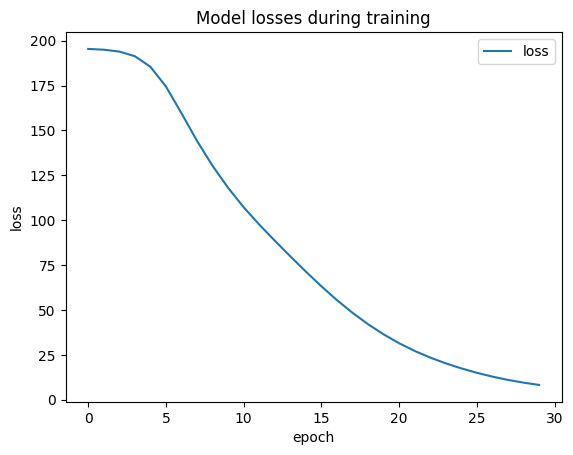

In [74]:
# Plot changes in model loss during training


if start_train:

    plt.plot(history.history["loss"])
    # plt.plot(history.history["regularization_loss"])
    # plt.plot(history.history["total_loss"])
    plt.title("Model losses during training")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["loss"], loc="upper right")
    plt.show()

In [75]:
if start_train:
    train_accuracy = candidates_model.evaluate(
        cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

    test_accuracy = candidates_model.evaluate(
        cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

    print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
    print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

9/9 [==============================] - 2s 252ms/step - factorized_top_k/top_1_categorical_accuracy: 0.5577 - factorized_top_k/top_5_categorical_accuracy: 0.9306 - factorized_top_k/top_10_categorical_accuracy: 0.9509 - factorized_top_k/top_50_categorical_accuracy: 0.9769 - factorized_top_k/top_100_categorical_accuracy: 0.9836 - loss: 1540.9709 - regularization_loss: 0.0000e+00 - total_loss: 1540.9709
Top-100 accuracy (train): 1.00.
Top-100 accuracy (test): 0.98.


<b>Serving</b>

In [76]:
candidates_model.load_weights(filepath='./weights/trained_n_personalized_model')

In [77]:
!pip install scann

ERROR: Could not find a version that satisfies the requirement scann (from versions: none)
ERROR: No matching distribution found for scann


In [ ]:
# recommends 100 movies out of the entire merchant dataset.

index = tfrs.layers.factorized_top_k.ScaNN(
    distance_measure = 'dot_product',
    num_leaves = 100,
    num_leaves_to_search = 10,
    training_iterations = 12,
    dimensions_per_block = 2,
    parallelize_batch_searches = True,
    query_model=candidates_model.query_model,
    k = 100
)

In [ ]:
trained_index = index.index_from_dataset(
  tf.data.Dataset.zip((
    movies.batch(100).map(lambda x: x["movie_id"]), 
    movies.batch(100).map(lambda x: {
      'movie_id':x["movie_id"],
      'total_views':x["total_views"],
      'movie_title':x["movie_title"],
      'genre1':x["genre1"],
      }).map(candidates_model.candidate_model)))
)

In [ ]:
# Input date in the format "12/12/2022"
date_str = "01/16/1998"

# Convert the date string to a datetime object
date_obj = datetime.strptime(date_str, "%m/%d/%Y")

# Convert the datetime object to a Unix timestamp
unix_timestamp = int(date_obj.timestamp())
# Extract the day of the week
day_of_week = date_obj.strftime("%A")

print(f'date_obj:{date_obj}')
print("Unix Timestamp:", unix_timestamp)
print(f"day of week:", day_of_week)

In [ ]:
light_user_ratings_df['ordered_unix_timestamp'] = pd.to_datetime(light_user_ratings_df['unix_timestamp'], unit='s')
light_user_ratings_df = light_user_ratings_df.sort_values(['user_id', 'ordered_unix_timestamp'])

light_user_ratings_df

In [ ]:
index_movie = dict(movies_df[['movie_id','movie_title']].to_numpy())
index_movie

In [ ]:
# single user test
scores , titles = trained_index(queries = {
    'user_id':tf.constant(['id_103']),
    'movie_id':tf.constant(['id_181']),
    'shift':tf.constant(['Noon']),
    'day_of_week':tf.constant(['Monday']),
    }, k = 50
)


print("Recommendations for user id_103 who watched the movie Return of the Jedi (1983)")

titles = [index_movie[idx.decode('utf-8')] for idx in titles[0, :].numpy()]

In [ ]:
# now let's evaluate for the entire dataset for light_users
# the function bellow generates 100 candidates for each row and measure if the watched movie is in the batch 
# of candidates. True for Yes and False for No. Then, it is summed up and  

def predict( 
    user_id:str, 
    movie_id:str,
    shift:str,
    day_of_week:str
):

    scores, titles = index(
        {
        'user_id':tf.constant([user_id]),
        'movie_id':tf.constant([movie_id]),
        'day_of_week':tf.constant([day_of_week]),
        'shift':tf.constant([shift]),
        },k = 100
    )

    if movie_id in titles[0]:
        # print(True)
        del titles
        return True
    else:
        del titles
        # print(False)
        return False

In [ ]:
# According to the results bellow, 90~94% of the interactions are covered by the candidates generation generated by
# the enricheded two-tower model. 

filtered_df = light_user_ratings_df[['user_id','movie_id', 'day_of_week', 'shift']]

df_evaluation = np.vstack(map(predict, 
    filtered_df['user_id'],
    filtered_df['movie_id'],
    filtered_df['day_of_week'],
    filtered_df['shift'],
    ))

final_df = pd.DataFrame(df_evaluation, index = filtered_df.index).rename(columns = {0:'score'})

final_df[final_df.score==True].shape[0]/final_df.shape[0]

<b>Kaggle</b>

Tensorflow comes with a library called TensorFlow Recommenders (TFRS), built on keras for building a recommender system<br />

This library offers a rich set of features and functionalities, for wide range of recommendation tasks

In [ ]:
#671 user ratings for about 9000 movies
ratings_df = pd.read_csv('./FinalProjData/ratings_small.csv')

ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

ratings_df.head()

In [ ]:
movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

In [ ]:
ratings_df['userId'] = ratings_df['userId'].astype(str)

ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])


In [ ]:
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

In [ ]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

In [ ]:
class MovieModel(tfrs.models.Model):

    def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
        # We take the loss weights in the constructor: this allows us to instantiate
        # several model objects with different loss weights.

        super().__init__()

        embedding_dimension = 64

        # User and movie models.
        self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
            vocabulary=unique_movie_titles, mask_token=None),
          tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # A small model to take in user and movie embeddings and predict ratings.
        # We can make this as complicated as we want as long as we output a scalar
        # as our prediction.
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        # The tasks.
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.movie_model)
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["userId"])
        # And pick out the movie features and pass them into the movie model.
        movie_embeddings = self.movie_model(features["original_title"])

        return (
            user_embeddings,
            movie_embeddings,
            # We apply the multi-layered rating model to a concatentation of
            # user and movie embeddings.
            self.rating_model(
                tf.concat([user_embeddings, movie_embeddings], axis=1)
            ),
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        ratings = features.pop("rating")

        user_embeddings, movie_embeddings, rating_predictions = self(features)

        # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

        # And combine them using the loss weights.
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

In [ ]:
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

model.fit(cached_train, epochs=3)

In [ ]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

In [ ]:
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

In [ ]:
predict_movie(123, 5)

In [ ]:
predict_rating(123,'Minions')

In [ ]:
#  So, le't examine User 123 from historical data
ratings_df[ratings_df['userId'] == '123']

In [ ]:
# Get meta data for predicted movie
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(['123']))
pred_movies = pd.DataFrame({'original_title': [i.decode('utf-8') for i in titles[0,:5].numpy()]})

pred_df = pred_movies.merge(ratings_df[['original_title', 'genres', 'overview']], on='original_title', how='left')
pred_df = pred_df[~pred_df['original_title'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

pred_df

At a glance, we can see if User 123 love watching Drama movies most of the time. He/She also gives a good rating for that genre. In our recommendation, We give 5 more Drama movies that we expect him/her to love the movies in a similar way with the previous watched movies.

In our dataset, we don't see any Animation movies that have been watched by User 123. So, it's not a surprise if the estimated rating for Minions is quite low